Loan prediction contest on Analytics Vidhya.

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
plt.style.use('seaborn')

In [207]:
# Read the data
train = pd.read_csv('train.csv')
test_X = pd.read_csv('test.csv')
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [208]:
train_Y = train.pop('Loan_Status')
train.pop('Loan_ID')
train_X = train
loan_id = test_X.pop('Loan_ID')

print('train_X =', train_X.shape)
print('train_Y =', train_Y.shape)
print('test_X =', test_X.shape)

train_X = (614, 11)
train_Y = (614,)
test_X = (367, 11)


In [209]:
train_X.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64

In [210]:
test_X.isnull().sum()

Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [211]:
# Deal with the missing values
for column in ["Gender", "Married", "Dependents", "Self_Employed",
               "Loan_Amount_Term", "Credit_History"]:
    train_X[column].fillna(train_X[column].mode()[0], inplace=True)
    test_X[column].fillna(test_X[column].mode()[0], inplace=True)

train_X['LoanAmount'].fillna(train_X['LoanAmount'].mean(), inplace=True)
test_X['LoanAmount'].fillna(test_X['LoanAmount'].mean(), inplace=True) 

In [212]:
df = pd.concat([train_X,test_X], ignore_index=True)
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [213]:
for column in df.columns:
  if column in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
    continue
  else:  
    print('%s:' %column, df[column].unique(),'\n')

Gender: ['Male' 'Female'] 

Married: ['No' 'Yes'] 

Dependents: ['0' '1' '2' '3+'] 

Education: ['Graduate' 'Not Graduate'] 

Self_Employed: ['No' 'Yes'] 

Loan_Amount_Term: [360. 120. 240. 180.  60. 300. 480.  36.  84.  12. 350.   6.] 

Credit_History: [1. 0.] 

Property_Area: ['Urban' 'Rural' 'Semiurban'] 



In [214]:
# Categorical to Numerical
train_X = pd.get_dummies(train_X, columns=["Gender", "Married",
                            "Education", "Self_Employed", "Property_Area"])
test_X = pd.get_dummies(test_X, columns=["Gender", "Married",
                            "Education", "Self_Employed", "Property_Area"])
train_X['Dependents'] = [0.0 if x=='0' else 1.0 if x=='1' else 2.0 if x=='2' else 3 for x in train_X['Dependents']]
test_X['Dependents'] = [0.0 if x=='0' else 1.0 if x=='1' else 2.0 if x=='2' else 3 for x in test_X['Dependents']]
train_Y = [1.0 if x=='Y' else 0.0 for x in train_Y]

In [ ]:
# # Change categorical data to numerical data 
# df['Gender'] = [1.0 if x=='Male' else 0.0 for x in df['Gender']]
# df['Married'] = [1.0 if x=='Yes' else 0.0 for x in df['Married']]
# df['Education'] = [1.0 if x=='Graduate' else 0.0 for x in df["Education"]]
# df['Self_Employed'] = [1.0 if x=='Yes' else 0.0 for x in df["Self_Employed"]]
# df['Property_Area'] = [0.0 if x=='Urban' else 1.0 if x=='Semiurban' else 2 for x in df["Property_Area"]]
# df['Dependents'] = [0.0 if x=='0' else 1.0 if x=='1' else 2.0 if x=='2' else 3 for x in df['Dependents']]
# train_Y = [1.0 if x=='Y' else 0.0 for x in train_Y]

In [215]:
print('train_X=',train_X.shape)
print('test_X=',test_X.shape)

train_X= (614, 17)
test_X= (367, 17)


In [216]:
# Normalize the data
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)
train_Y = np.asarray(train_Y, dtype='float64')

In [228]:
# build the model using functional API
def build_model(inputs, units, batch_size, lr):
  adam = tf.keras.optimizers.Adam(
    learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
  callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

  x = Dense(units=units, name='first_dense', activation='relu')(inputs)
  x = Dense(units=1, name='Output', activation='sigmoid')(x)
  model =  Model(inputs=inputs, outputs=x)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics='accuracy')
  history = model.fit(train_X, train_Y, batch_size=batch_size, epochs=1000,
                      callbacks=[callback] ,verbose=0)
  return history


inputs = Input(shape=(17,), name='input_layer')
result = []
for units in [32, 64, 128, 256]:
  for batch_size in [32, 64, 128, 256]:
    for lr in [0.001, 0.01, 0.1]:
      history = build_model(inputs, units, batch_size, lr)
      print(history.history['accuracy'][-1],'for (units, batch_size, lr)={}'
            .format((units,batch_size,lr)))

0.8110749125480652 for (units, batch_size, lr)=(32, 32, 0.001)
0.8127036094665527 for (units, batch_size, lr)=(32, 32, 0.01)
0.8143322467803955 for (units, batch_size, lr)=(32, 32, 0.1)
0.8127036094665527 for (units, batch_size, lr)=(32, 64, 0.001)
0.8110749125480652 for (units, batch_size, lr)=(32, 64, 0.01)
0.8143322467803955 for (units, batch_size, lr)=(32, 64, 0.1)
0.6872963905334473 for (units, batch_size, lr)=(32, 128, 0.001)
0.8110749125480652 for (units, batch_size, lr)=(32, 128, 0.01)
0.8094462752342224 for (units, batch_size, lr)=(32, 128, 0.1)
0.6872963905334473 for (units, batch_size, lr)=(32, 256, 0.001)
0.8110749125480652 for (units, batch_size, lr)=(32, 256, 0.01)
0.8143322467803955 for (units, batch_size, lr)=(32, 256, 0.1)
0.8127036094665527 for (units, batch_size, lr)=(64, 32, 0.001)
0.8110749125480652 for (units, batch_size, lr)=(64, 32, 0.01)
0.8159608840942383 for (units, batch_size, lr)=(64, 32, 0.1)
0.8110749125480652 for (units, batch_size, lr)=(64, 64, 0.001)
0

Epoch 1/2000
3/3 [==============================] - 0s 4ms/step - loss: 0.7115 - accuracy: 0.4105
Epoch 2/2000
3/3 [==============================] - 0s 4ms/step - loss: 0.6695 - accuracy: 0.6443
Epoch 3/2000
3/3 [==============================] - 0s 4ms/step - loss: 0.6350 - accuracy: 0.6937
Epoch 4/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.6200 - accuracy: 0.6745
Epoch 5/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.5972 - accuracy: 0.6947
Epoch 6/2000
3/3 [==============================] - 0s 4ms/step - loss: 0.5945 - accuracy: 0.6874
Epoch 7/2000
3/3 [==============================] - 0s 4ms/step - loss: 0.5855 - accuracy: 0.6937
Epoch 8/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.5831 - accuracy: 0.6908
Epoch 9/2000
3/3 [==============================] - 0s 4ms/step - loss: 0.5890 - accuracy: 0.6820
Epoch 10/2000
3/3 [==============================] - 0s 3ms/step - loss: 0.5860 - accuracy: 0.6825
Epoch 11/2000
3/3 [

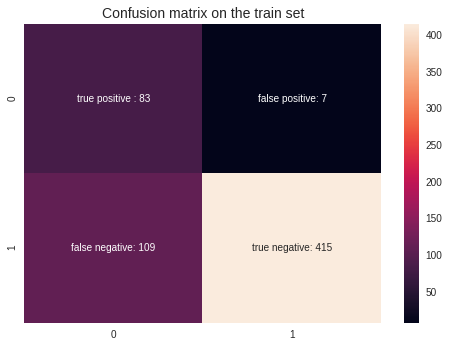

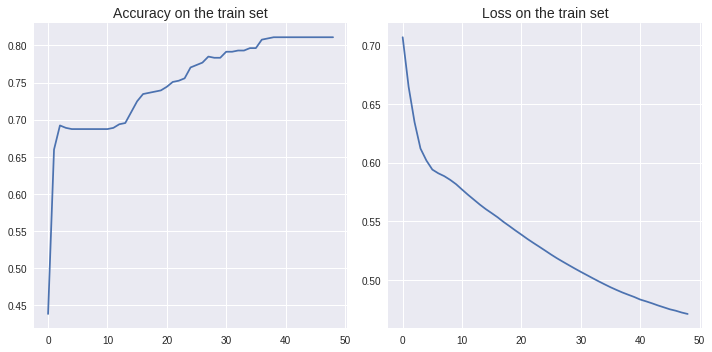

In [237]:
def build_model():

  adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
  callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

  inputs = Input(shape=(17,), name='input_layer')
  x = Dense(units=128, name='first_dense', activation='relu')(inputs)
  x = Dense(units=1, name='Output', activation='sigmoid')(x)
  model =  Model(inputs=inputs, outputs=x)

  tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics='accuracy')
  history = model.fit(train_X, train_Y, batch_size=256, epochs=2000,
                       callbacks=[callback], verbose=1)
  
  return [model, history, pred_df]

[model, history, pred_df] = build_model()
predictions = model.predict(test_X)
pred = ['Y' if x >=0.5 else 'N' for x in predictions]
pred_dic = list(zip(loan_id, pred))
pred_df = pd.DataFrame(pred_dic, columns=['Loan_ID', 'Loan_Status'])
pred_df.to_csv ('predict.csv', index = False, header=True)

# Confusion Matrix on the trainig set
train_pred = model.predict(train_X)
train_pred = [1 if x >=0.5 else 0 for x in train_pred]
CM = confusion_matrix(train_pred, train_Y)
labels = np.array(['true positive : %i' %CM[0][0] , 'false positive: %i' %CM[0][1],
                  'false negative: %i'%CM[1][0], 'true negative: %i'%CM[1][1]])
labels = labels.reshape((2,2))
sns.heatmap(CM, annot=labels, cmap=None, fmt='');
plt.title('Confusion matrix on the train set', fontsize=14)
plt.show()

results = history.history
epochs = len(history.history['loss'])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.arange(epochs), results['accuracy'])
plt.title('Accuracy on the train set', fontsize=14)
plt.subplot(122)
plt.plot(np.arange(epochs), results['loss'])
plt.title('Loss on the train set', fontsize=14)
plt.tight_layout()
plt.show()

The model has %81 accuracy on the train set and %78 accuracy on the test set. Test labels are not available from analytics vidhya website.